# 1. Setup

In [1]:
#@title Install required packages. { form-width: "320px" }
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

#!pip install tensorboardX

1.11.0+cu113


In [2]:
#@title Import dependencies { form-width: "320px" }
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn

# 2. Handling Plumbing Graphs
Let us define some functions to deal with plumbing graphs.

In [3]:
#@title A Function to create a graph from numpy dense arrays { form-width: "320px" }
def create_graph(x, a, y = None):
  pyg_graph = Data()
  nx_graph = nx.from_numpy_matrix(a) # create a 'networkx' graph from a dense adjacency matrix 'a'
  pyg_graph = from_networkx(nx_graph) # convert a networkx graph into a pyg graph 
  pyg_graph.weight = None
  pyg_graph.x = torch.tensor(x.reshape(-1, 1), dtype = torch.float32) # feeding node features
  #pyg_graph.y = y # feeding labels
  return pyg_graph

In [4]:
#@title A Fuction for Neumann moves { form-width: "320px" }
def neumann_move(g_graph, neuman_move_type = np.random.randint(1,4)):
    node_label = g_graph.x.numpy()
    node_label = node_label.flatten()
    #graph_y = g_graph.y
    n = len(node_label)
    if n == 1:
        adjacency = np.zeros((1,1))
    else:
        adjacency = to_dense_adj(g_graph.edge_index)
        adjacency = adjacency.numpy()[0, :, :]
    chosen_vertex = np.random.randint(0, n)
    linked_vs=[]
    for j in range(n):
        if adjacency[chosen_vertex, j] == 1:
            linked_vs = np.append(linked_vs, j)
    linked_vs = np.array(linked_vs, dtype=int)
    sign = 1 if np.random.random() < 0.5 else -1
    if len(linked_vs) == 0:
        neuman_move_type = 2 if np.random.random() < 0.5 else 3
    if neuman_move_type == 1:
        chosen_linked_vertex = linked_vs[np.random.randint(0, len(linked_vs))]
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        node_label[chosen_linked_vertex] = node_label[chosen_linked_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = adjacency[chosen_linked_vertex, n ] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = adjacency[n, chosen_linked_vertex] = 1
        adjacency[chosen_vertex, chosen_linked_vertex] = adjacency[chosen_linked_vertex, chosen_vertex] = 0
    elif neuman_move_type == 2:
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = 1        
    elif neuman_move_type == 3:
        node_label = np.append(node_label, 0)
        node_diff = np.random.randint(-20, 20)
        node_label = np.append(node_label, node_diff)
        node_label[chosen_vertex] = node_label[chosen_vertex] - node_diff
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency = np.append(adjacency, np.zeros((n + 1, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 2)), axis = 0)
        adjacency[chosen_vertex, n] = adjacency[n, chosen_vertex] = 1
        adjacency[n, n + 1] = adjacency[n + 1, n] = 1
        if len(linked_vs) > 0:
            np.random.shuffle(linked_vs)
            n_split = np.random.randint(0, len(linked_vs))
            if n_split != 0 or n_split != len(linked_vs)-1:
                linked_chosen_2 = linked_vs[n_split:]
                for i in linked_chosen_2:
                    adjacency[chosen_vertex, i] = adjacency[i, chosen_vertex] = 0
                    adjacency[n + 1, i] = adjacency[i, n + 1] = 1
    node_label = node_label.reshape(-1, 1)
    return create_graph(node_label, adjacency)

In [5]:
#@title A Function to Plot a Graph { form-width: "320px" }
def plot_graph(pyg_graph):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  g = to_networkx(pyg_graph, to_undirected=True)
  labeldict = {}
  for i in range(pyg_graph.num_nodes):
      labeldict[i]=pyg_graph.x[i].item()

  pos_nodes = nx.kamada_kawai_layout(g)
  pos_attrs = {}
  for node, coords in pos_nodes.items():
      pos_attrs[node] = (coords[0], coords[1] + 0.08)
  nx.draw(g, pos_nodes, node_color='black', node_size=30)
  nx.draw_networkx_labels(g, pos_attrs, labels=labeldict)
  plt.show()

In [6]:
#@title Creating a random Graph
def random_graph():
  n = np.random.randint(1,15)
  x = np.random.randint(-10, 10, size = n)
  a=np.zeros((n, n))
  for i in range(1,n):
    j=np.random.randint(i)
    a[i,j]=a[j,i]=1
  return create_graph(x, a)

As an example, we are trying to create a random graph by using `random_graph()` function and plot it by the function named `plot_graph()`.

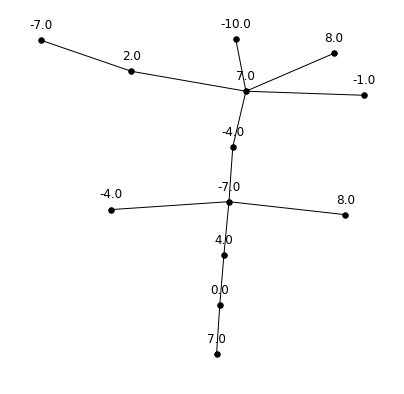

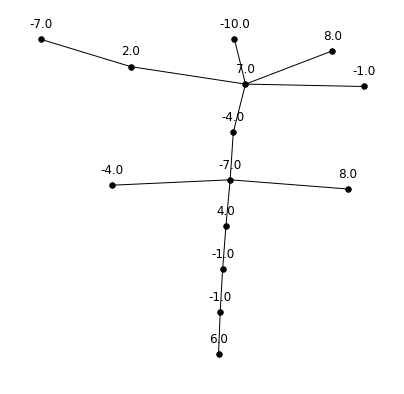

Data(edge_index=[2, 26], num_nodes=14, x=[14, 1])


In [7]:
#@title An Example { form-width: "320px" }
g_graph = random_graph()
plot_graph(g_graph)
g1_graph = neumann_move(g_graph)
plot_graph(g1_graph)
print(g1_graph)

# 3. Preparing Datasets

In [8]:
#@title Defining PairData as a subclass of Data for storing two graphs { form-width: "320px" }
class PairData(Data):
  def __init__(self, edge_index_s=None, x_s=None, edge_index_t=None, x_t=None, y = None):
    super().__init__()
    self.edge_index_s = edge_index_s
    self.x_s = x_s
    self.edge_index_t = edge_index_t
    self.x_t = x_t
    self.y = y
  def __inc__(self, key, value, *args, **kwargs):
    if key == 'edge_index_s':
        return self.x_s.size(0)
    if key == 'edge_index_t':
        return self.x_t.size(0)
    else:
        return super().__inc__(key, value, *args, **kwargs)

In [9]:
#@title Generate a random dataset { form-width: "320px" }
def generate_dataset(n_pairs = 50):
    data_list = []
    
    for j in range(0, n_pairs):
      pos = 1 if np.random.random() < 0.5 else -1
      g1 = random_graph()
      for i in range(np.random.randint(1,11)):
        g1 = neumann_move(g1)
      if pos == 1:
        g2 = g1
        for i in range(np.random.randint(1,11)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1,11)):
          g2 = neumann_move(g2)
      else:
        g2 = random_graph()
        for i in range(np.random.randint(1,11)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1,11)):
          g2 = neumann_move(g2)
      #y = torch.tensor([pos]).unsqueeze(1)
      if pos == 1:
        y = torch.tensor([pos])
      else:
        y = torch.tensor([0])
      
      # Normalize
      g1.x = F.normalize(g1.x, p = 2, dim = 0)
      g2.x = F.normalize(g2.x, p = 2, dim = 0)

      # Save
      data_list.append(PairData(g1.edge_index, g1.x, g2.edge_index, g2.x, y))
    return data_list

In [10]:
#@title Create Sets for training and testing { form-width: "320px" }
#import torch_geometric.transforms as T

dataset = generate_dataset(n_pairs = 1500)
#dataset.transform = T.NormalizeFeatures()
data_size = len(dataset)
train_loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])

# 4. Several Models and Testing

## 4.1 Model (1) - GINConv Layers

In [11]:
#@title Making 'GNNStack' model with GINConv layers { form-width: "320px" }

class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(2*hidden_dim, 2*hidden_dim), nn.Dropout(0.25), 
            nn.Linear(2*hidden_dim, output_dim))
        
        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
      #return pyg_nn.GCNConv(input_dim, hidden_dim)
        return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x_s, edge_index_s, x_t, edge_index_t, x_s_batch, x_t_batch = data.x_s, data.edge_index_s, data.x_t, data.edge_index_t, data.x_s_batch, data.x_t_batch
        
        for i in range(self.num_layers):
            x_s = self.convs[i](x_s, edge_index_s)
            x_s = F.relu(x_s)
            x_s = F.dropout(x_s, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x_s = self.lns[i](x_s)

        x_s = pyg_nn.global_mean_pool(x_s, x_s_batch)

        for i in range(self.num_layers):
            x_t = self.convs[i](x_t, edge_index_t)
            x_t = F.relu(x_t)
            x_t = F.dropout(x_t, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x_t = self.lns[i](x_t)

        x_t = pyg_nn.global_mean_pool(x_t, x_t_batch)

        x = torch.cat((x_s, x_t), dim = 1)
        x = self.post_mp(x)
        

        return x
model_1 = GNNStack(1, hidden_dim=64, output_dim = 2)
print(model_1)

GNNStack(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
  )
  (lns): ModuleList(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [12]:
#@title Train and Test Functions { form-width: "320px" }
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         x = model(data)  # Perform a single forward pass.
         loss = criterion(x, data.y)  # Compute the loss.
         optimizer.zero_grad()
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         #optimizer.zero_grad()  # Clear gradients.

def test(loader):
  model.eval()
  correct = 0
  #loss = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
      out = model(data)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  return correct / len(loader.dataset)  # Derive ratio of correct predictions.

Results from GNNStack model with GINConv Layers
Epoch: 001, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 020, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 040, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 060, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 080, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 100, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 120, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 140, Train Acc: 0.4625, Test Acc: 0.5000
Epoch: 160, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 180, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 200, Train Acc: 0.5375, Test Acc: 0.5000
Train Accuracy:
    Minimum  0.4625 
    Maximum  0.5375
Test Accuracy:
    Minimum  0.5000 
    Maximum  0.5000


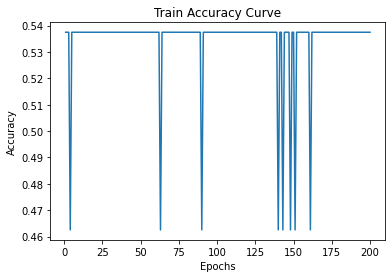

In [13]:
#@title Test Model-1 { form-width: "320px" }
model = model_1
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_acc = []
test_acc = []
print('Results from GNNStack model with GINConv Layers')
print('==================================================')
for epoch in range(1, 201):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('==================================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f}')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f}')

fig, ax = plt.subplots()
epoch = range(1, 201)
ax.plot(epoch, train_acc)
ax.set_xlabel('Epochs')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("Train Accuracy Curve")  # Add a title to the axes.
plt.show()

The test tells us that the model with `GINConv` layers does not learn at all and it is not useful for us.

## 4.2 Model (2) - GCNConv Layers

In [14]:
#@title Making 'GCN' model with GCNConv layers { form-width: "320px" }
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = pyg_nn.GCNConv(1, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(2*hidden_channels, 2)

    def forward(self, data):
        # 1. Obtain node embeddings for x_s
        x_s = self.conv1(data.x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv2(x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv3(x_s, data.edge_index_s)

        # 2. Obtain node embeddings for x_t
        x_t = self.conv1(data.x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2(x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv3(x_t, data.edge_index_t)

        # 3. Readout layer
        x_s = pyg_nn.global_mean_pool(x_s, data.x_s_batch)
        x_t = pyg_nn.global_mean_pool(x_t, data.x_t_batch)
        x = torch.cat((x_s, x_t), dim = 1)

        # 4. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model_2 = GCN(hidden_channels=64)
print(model_2)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


Results from GCN model with GCNConv Layers
Epoch: 001, Train Acc: 0.4533, Test Acc: 0.4933
Epoch: 020, Train Acc: 0.6283, Test Acc: 0.6567
Epoch: 040, Train Acc: 0.6808, Test Acc: 0.6500
Epoch: 060, Train Acc: 0.6692, Test Acc: 0.6033
Epoch: 080, Train Acc: 0.6808, Test Acc: 0.6333
Epoch: 100, Train Acc: 0.6733, Test Acc: 0.6467
Epoch: 120, Train Acc: 0.6450, Test Acc: 0.6767
Epoch: 140, Train Acc: 0.6708, Test Acc: 0.6300
Epoch: 160, Train Acc: 0.6608, Test Acc: 0.6033
Epoch: 180, Train Acc: 0.6683, Test Acc: 0.6233
Epoch: 200, Train Acc: 0.6100, Test Acc: 0.6533
Epoch: 220, Train Acc: 0.6650, Test Acc: 0.6300
Epoch: 240, Train Acc: 0.6658, Test Acc: 0.6267
Epoch: 260, Train Acc: 0.6667, Test Acc: 0.6167
Epoch: 280, Train Acc: 0.6733, Test Acc: 0.6400
Epoch: 300, Train Acc: 0.6808, Test Acc: 0.6400
Epoch: 320, Train Acc: 0.6750, Test Acc: 0.6333
Epoch: 340, Train Acc: 0.6883, Test Acc: 0.6600
Epoch: 360, Train Acc: 0.6783, Test Acc: 0.6233
Epoch: 380, Train Acc: 0.6775, Test Acc: 0.63

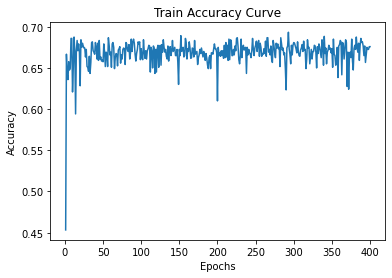

In [15]:
#@title Test Model-2 { form-width: "320px" }
model = model_2
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_acc = []
test_acc = []
print('Results from GCN model with GCNConv Layers')
print('===========================================')
for epoch in range(1, 401):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, ax = plt.subplots()
epoch = range(1, 401)
ax.plot(epoch, train_acc)
ax.set_xlabel('Epochs')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("Train Accuracy Curve")  # Add a title to the axes.
plt.show()

The model with `GCNConv` layers works better than the previous model with `GINConv` layers, but train accuracy is still lower than 70 %.

## 4.3 Model (3) - GraphConv Layers

In [16]:
#@title 'GNN' model with GraphConv Layers { form-width: "320px" }
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(1, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(2*hidden_channels, 2)

    def forward(self, data):
        # 1. Obtain node embeddings for x_s
        x_s = self.conv1(data.x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv2(x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv3(x_s, data.edge_index_s)

        # 2. Obtain node embeddings for x_t
        x_t = self.conv1(data.x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2(x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv3(x_t, data.edge_index_t)

        # 3. Readout layer
        x_s = pyg_nn.global_mean_pool(x_s, data.x_s_batch)
        x_t = pyg_nn.global_mean_pool(x_t, data.x_t_batch)
        x = torch.cat((x_s, x_t), dim = 1)

        # 4. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model_3 = GNN(hidden_channels=64)
print(model_3)

GNN(
  (conv1): GraphConv(1, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


Results from GNN model with GraphConv Layers
Epoch: 001, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 020, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 040, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 060, Train Acc: 0.4625, Test Acc: 0.5000
Epoch: 080, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 100, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 120, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 140, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 160, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 180, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 200, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 220, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 240, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 260, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 280, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 300, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 320, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 340, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 360, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 380, Train Acc: 0.5375, Test Acc: 0.

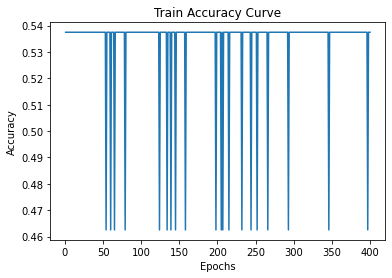

In [17]:
#@title Test Model-3 { form-width: "320px" }
model = model_3
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_acc = []
test_acc = []
print('Results from GNN model with GraphConv Layers')
print('===========================================')
for epoch in range(1, 401):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, ax = plt.subplots()
epoch = range(1, 401)
ax.plot(epoch, train_acc)
ax.set_xlabel('Epochs')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("Train Accuracy Curve")  # Add a title to the axes.
plt.show()

Sometimes, it works well, but it refuses to work sometimes. (Don't know why. Seems like it depends on randomly chosen dataset.)

When the model works well, it performs best among previous 3 models.

Now we are going to build a model using two promising layers `GCNConv` and `GraphConv` and test it.

In [18]:
#@title GNN Model with mixed layers using `GCNConv` and `GraphConv`. { form-width: "320px" }
class Two_Convs(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Two_Convs, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(1, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(2*hidden_channels, 2)

    def forward(self, data):
        # 1. Obtain node embeddings for x_s
        x_s = self.conv1(data.x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv2(x_s, data.edge_index_s)
        x_s = x_s.relu()
        x_s = self.conv3(x_s, data.edge_index_s)

        # 2. Obtain node embeddings for x_t
        x_t = self.conv1(data.x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv2(x_t, data.edge_index_t)
        x_t = x_t.relu()
        x_t = self.conv3(x_t, data.edge_index_t)

        # 3. Readout layer
        x_s = pyg_nn.global_mean_pool(x_s, data.x_s_batch)
        x_t = pyg_nn.global_mean_pool(x_t, data.x_t_batch)
        x = torch.cat((x_s, x_t), dim = 1)

        # 4. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model_4 = Two_Convs(hidden_channels=64)
print(model_4)

Two_Convs(
  (conv1): GraphConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


Results from `Two_Conv` model with GraphConv and GCNConv Layers
Epoch: 001, Train Acc: 0.6750, Test Acc: 0.6467
Epoch: 020, Train Acc: 0.6867, Test Acc: 0.6500
Epoch: 040, Train Acc: 0.7108, Test Acc: 0.6700
Epoch: 060, Train Acc: 0.7217, Test Acc: 0.7033
Epoch: 080, Train Acc: 0.7367, Test Acc: 0.7267
Epoch: 100, Train Acc: 0.7550, Test Acc: 0.7300
Epoch: 120, Train Acc: 0.7408, Test Acc: 0.7500
Epoch: 140, Train Acc: 0.7275, Test Acc: 0.7100
Epoch: 160, Train Acc: 0.7225, Test Acc: 0.7233
Epoch: 180, Train Acc: 0.7550, Test Acc: 0.7567
Epoch: 200, Train Acc: 0.7725, Test Acc: 0.7433
Epoch: 220, Train Acc: 0.7583, Test Acc: 0.7100
Epoch: 240, Train Acc: 0.7625, Test Acc: 0.7100
Epoch: 260, Train Acc: 0.7450, Test Acc: 0.7000
Epoch: 280, Train Acc: 0.7633, Test Acc: 0.7133
Epoch: 300, Train Acc: 0.7692, Test Acc: 0.7267
Epoch: 320, Train Acc: 0.7750, Test Acc: 0.7333
Epoch: 340, Train Acc: 0.7358, Test Acc: 0.6767
Epoch: 360, Train Acc: 0.7525, Test Acc: 0.7200
Epoch: 380, Train Acc: 0

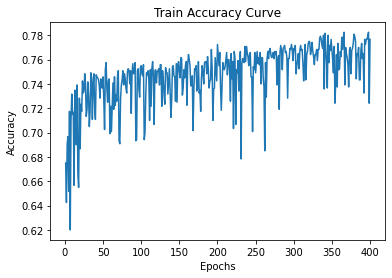

In [19]:
#@title Test Model-4 { form-width: "320px" }
model = model_4
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_acc = []
test_acc = []
print('Results from `Two_Conv` model with GraphConv and GCNConv Layers')
print('===========================================')
for epoch in range(1, 401):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, ax = plt.subplots()
epoch = range(1, 401)
ax.plot(epoch, train_acc)
ax.set_xlabel('Epochs')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("Train Accuracy Curve")  # Add a title to the axes.
plt.show()

That's better!

## 4.4 Graph Attention Network(GAT)

In [20]:
#@title GATConv Layer { form-width: "320px" }
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.lin = nn.Linear(4, 2)
        self.conv1 = GATConv(1, self.hid, heads=self.in_head, dropout=0.5)
        self.conv2 = GATConv(self.hid*self.in_head, 2, concat=False,
                             heads=self.out_head, dropout=0.5)

    def forward(self, data):
        x_s, edge_index_s = data.x_s, data.edge_index_s
        x_t, edge_index_t = data.x_t, data.edge_index_t
        
        # Process for x_s        
        x_s = F.dropout(x_s, p=0.6, training=self.training)
        x_s = self.conv1(x_s, edge_index_s)
        x_s = F.elu(x_s)
        x_s = F.dropout(x_s, p=0.6, training=self.training)
        x_s = self.conv2(x_s, edge_index_s)
        
        # Process for x_t
        x_t = F.dropout(x_t, p=0.6, training=self.training)
        x_t = self.conv1(x_t, edge_index_t)
        x_t = F.elu(x_t)
        x_t = F.dropout(x_t, p=0.6, training=self.training)
        x_t = self.conv2(x_t, edge_index_t)

        # Concatenate x_s and x_t
        x_s = pyg_nn.global_mean_pool(x_s, data.x_s_batch)
        x_t = pyg_nn.global_mean_pool(x_t, data.x_t_batch)
        x = torch.cat((x_s, x_t), dim = 1)

        # Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model_5 = GAT()
print(model_5)

GAT(
  (lin): Linear(in_features=4, out_features=2, bias=True)
  (conv1): GATConv(1, 8, heads=8)
  (conv2): GATConv(64, 2, heads=1)
)


Results from `GAT` model with two `GATConv` Layers
Epoch: 001, Train Acc: 0.5375, Test Acc: 0.5000
Epoch: 020, Train Acc: 0.5592, Test Acc: 0.5433
Epoch: 040, Train Acc: 0.5467, Test Acc: 0.5133
Epoch: 060, Train Acc: 0.5400, Test Acc: 0.5000
Epoch: 080, Train Acc: 0.5450, Test Acc: 0.5167
Epoch: 100, Train Acc: 0.5425, Test Acc: 0.5067
Epoch: 120, Train Acc: 0.5433, Test Acc: 0.5067
Epoch: 140, Train Acc: 0.5583, Test Acc: 0.5400
Epoch: 160, Train Acc: 0.5550, Test Acc: 0.5333
Epoch: 180, Train Acc: 0.5600, Test Acc: 0.5433
Epoch: 200, Train Acc: 0.6067, Test Acc: 0.5867
Epoch: 220, Train Acc: 0.5425, Test Acc: 0.5067
Epoch: 240, Train Acc: 0.5492, Test Acc: 0.5233
Epoch: 260, Train Acc: 0.5642, Test Acc: 0.5367
Epoch: 280, Train Acc: 0.5508, Test Acc: 0.5233
Epoch: 300, Train Acc: 0.5450, Test Acc: 0.5200
Epoch: 320, Train Acc: 0.5642, Test Acc: 0.5433
Epoch: 340, Train Acc: 0.5525, Test Acc: 0.5267
Epoch: 360, Train Acc: 0.5792, Test Acc: 0.5667
Epoch: 380, Train Acc: 0.5533, Test A

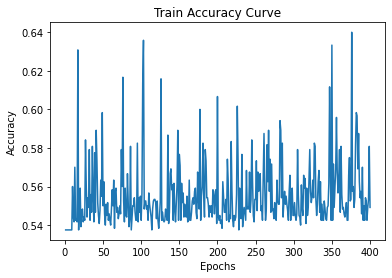

In [21]:
#@title Test Model-5 { form-width: "320px" }
model = model_5
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_acc = []
test_acc = []
print('Results from `GAT` model with two `GATConv` Layers')
print('===========================================')
for epoch in range(1, 401):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, ax = plt.subplots()
epoch = range(1, 401)
ax.plot(epoch, train_acc)
ax.set_xlabel('Epochs')  # Add an x-label to the axes.
ax.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax.set_title("Train Accuracy Curve")  # Add a title to the axes.
plt.show()

This is another trash!